# OU REVISITED
In this notebook I wil once again use the OU model as a framework for a statistical arbitrage model, however this time i will generate the weights using a feedforward neural network instead of a static rule based system as before, also allowing me to incorporate transaction costs in the training of the strategy

### 0) Imports and other preparations

In [1]:
LOOKBACK_PERIOD = 100 #2 days is the total lookback period

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import torch
from numpy.linalg import eig, norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import time

In [338]:
price_data  = pd.read_csv('futures_data.csv').set_index('close_time')
returns     = price_data.pct_change(1)
in_sample   = returns[:3*len(returns)//4]
out_sample  = returns[3*len(returns)//4+1:]

pct_ret     = in_sample.loc[:,in_sample.max() < 1]
#log_ret = pd.read_csv('log_returns.csv').set_index('close_time')[1:len(pct_ret)//2]

### 1) Generating the residual portfolios

This is currently done using a pca method as described in Avalanda and Lee (2008), however in the future newer techniques could be used like the one decribed in this paper: Two Machine Learning Approaches for Statistical Arbitrage Pairs Selection. based upon: Deep Clustering with Convolutional Autoencoders, by Xifeng Guo et al. 

In [270]:
def pca(returns:pd.DataFrame, res_cov_window_size:int = 252, loadings_window_size:int=30, amount_of_factors:int=5):
    '''
    Function that computes the percentage returns of a residual portfolio constructed using pca
    Also with the weights needed to construct all these portfolio's
    
    Residual_output  is a T x N matrix 
    Residual_portfolio is a T x N x N matrix where e.g res_portf[t,i, :] gives you the vector 
    with all the weights you need to construct the residual portfolio i at timestep t
    Recovering phi from residual portfolio can be done by slicing as follows res_portf[t,:,:]
    '''
    T, N                = returns.shape
    returns             = returns.to_numpy()
    residuals_output    = np.zeros((T, N), dtype=float)    
    residual_portfolio  = np.zeros((T, N, N), dtype=float)
    for t in range(res_cov_window_size+1,len(returns)):
        # only use the columns with no missing values
        idxsSelected = ~np.any(np.isnan(returns[(t - res_cov_window_size+1):t]), axis = 0).ravel()   
        if idxsSelected.sum() == 0:
            continue
        #calculate covariance
        res_cov_window = returns[(t - res_cov_window_size+1):t,idxsSelected]
        R_OoS           = returns[(t - res_cov_window_size+1):(t+1),idxsSelected] #TODO: adj for bias, original returns[(t - res_cov_window_size+1):(t+1),idxsSelected]
        res_mean = np.mean(res_cov_window,axis=0,keepdims=True)
        res_vol = np.sqrt(np.mean((res_cov_window-res_mean)**2,axis=0,keepdims=True))
        res_normalized = (res_cov_window - res_mean) / res_vol
        Corr = np.dot(res_normalized.T, res_normalized)
        eigenValues, eigenVectors = np.linalg.eigh(Corr)

        #calculate loadings
        w           = eigenVectors[:,-amount_of_factors:].real                      # w
        R           = res_cov_window[-loadings_window_size:,:]
        wtR         = res_cov_window[-loadings_window_size:,:] @ w                  # R * w 
        regr        = LinearRegression(fit_intercept=False, n_jobs=-1).fit(wtR,R)   
        beta        = regr.coef_                                                    #beta
        phi         = (np.eye(beta.shape[0]) - beta @ w.T)
        #TODO: is ther somethign wrong with the returns they use here??
        residuals   = phi @ R[-1,:].T
        residuals_output[t:(t+1),idxsSelected]                = residuals
        i = 0
        for idx, val in enumerate(idxsSelected):
            if val:  
                residual_portfolio[t:(t+1),idx,idxsSelected] = phi[i,:].reshape([1,-1])
                i += 1  
    return residuals_output, residual_portfolio

In [271]:
test                      = pct_ret
PCA, pca_portfolio        = pca(test) 
residuals                 = pd.DataFrame(PCA, index=test.index, columns=test.columns)

In [272]:
residuals

,BTCUSDT,ETHUSDT,BCHUSDT,XRPUSDT,EOSUSDT,LTCUSDT,TRXUSDT,ETCUSDT,LINKUSDT,XLMUSDT,...,WOOUSDT,JASMYUSDT,DARUSDT,GALUSDT,APEBUSD,FTMBUSD,DODOBUSD,GALABUSD,TRXBUSD,1000LUNCBUSD
close_time,,,,,,,,,,,,,,,,,,,,,
2019-09-09 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-09 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-10 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-10 12:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-09-11 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-30 00:00:00,0.006919,0.007186,0.001202,0.011316,-0.003953,-0.004496,0.000439,-0.014858,0.010068,0.016563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-30 12:00:00,-0.000328,-0.003610,0.004496,0.000842,-0.000893,-0.017837,-0.002115,-0.021034,0.000322,0.011759,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2022-05-31 00:00:00,0.000643,-0.001853,-0.012975,-0.008438,-0.000773,-0.002163,0.011974,-0.000990,0.003021,0.010390,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 2) Preprocessing the OU signals

In [273]:
def preprocess_ou(data:np.array, lookback:int=30):
    print("Start OU preprocess")
    signal_length = 4
    T,N = data.shape
    cumsums = np.cumsum(data, axis=0)
    windows = np.zeros((T-lookback, N, signal_length), dtype=np.float32)
    idxs_selected = np.zeros((T-lookback,N), dtype=bool)
    for t in range(lookback,T):
        # chooses stocks which have no missing returns in the t-th lookback window
        idxs_selected[t-lookback,:] = ~np.any(data[(t-lookback):t,:] == 0, axis=0).ravel() 
        idxs = idxs_selected[t-lookback,:]
        if t == lookback:
            x = cumsums[t-lookback:t,idxs].T
        else:
            # Probably unnecessary given the conv normalization, but is just to have the same setting as in the OU case
            x = cumsums[t-lookback:t,idxs].T - cumsums[t-lookback-1,idxs].reshape(int(sum(idxs)),1)
        Nx,Tx = x.shape
        #TODO: Is this where we make sure we dont have any look ahead bias?
        Ys = x[:,1:] #(N,T-1) 
        Xs = x[:,:-1]
        meansX = np.mean(Xs,axis=1) #(N)
        meansY = np.mean(Ys,axis=1)
        VarsX = np.var(Xs,axis=1) #N
        VarsY = np.var(Ys,axis=1)
        Covs = np.mean((Xs-meansX.reshape((Nx,1)))*(Ys-meansY.reshape((Nx,1))),axis=1) #N
        R2 = Covs**2/(VarsX*VarsY) #N
        bs = Covs/VarsX #N
        cs = (meansY - bs*meansX)
        mus = (cs/(1-bs+0.000001))
        mask = ((bs > 0) * (bs < 1))
        #kappas = -np.log(bs)/Deltat #if bs betwen 0 and 1
        residuals = Ys - bs.reshape((Nx,1))*Xs - cs.reshape((Nx,1)) #(N,T-1)
        sigmas = np.sqrt(np.var(residuals, axis=1)/np.abs(1-bs**2+0.000001)) #N
        signal = np.zeros((Nx))
        #signal =  (mus - Ys[:,-1])/sigmas * mask 
        signal[mask] = (mus[mask] - Ys[:,-1][mask])/sigmas[mask]
        windows[t-lookback,idxs,0] = Ys[:,-1]
        windows[t-lookback,idxs,1] = mus
        windows[t-lookback,idxs,2] = sigmas
        windows[t-lookback,idxs,3] = R2
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected before & mask: {np.sum(idxs_selected[t-lookback,:])}")
        idxs_selected[t-lookback,idxs] = idxs_selected[t-lookback,idxs] & mask
#         if (t-lookback) % 100 == 0:
#             logging.info(f"idxs_selected after & mask: {np.sum(idxs_selected[t-lookback,:])}")
    idxs_selected = torch.as_tensor(idxs_selected)
    print("Finish OU preprocess")
    return windows, idxs_selected

In [274]:
windows, idxs_selected = preprocess_ou(PCA, 30)
windows.shape #AXIS 0: time t, AXIS 1: asset, AXIS 2: signal value, mu, sigma, R2

Start OU preprocess
Finish OU preprocess


(1963, 142, 4)

(-4.0, 4.0)

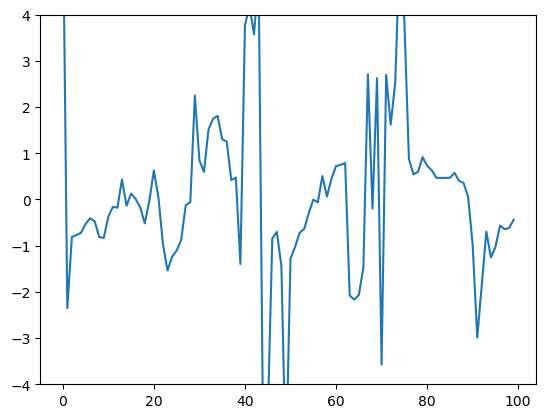

In [276]:
# following plot shows the generated signal for RUNEUSDT
# judging by this plot it looks pretty solid
plt.plot(((windows[-100:,1,0] - windows[-100:,1,1]) / windows[-100:,1,2]))
plt.ylim([-4,4])

### 3) Weight allocation model 

In [337]:
class OUFFN(nn.Module):
    def __init__(self, 
                 logdir,
                 lookback = 30,
                 random_seed=100, 
                 device = "cpu",
                 hidden_units = [4,4,4,4], 
                 dropout = 0.25):
        
        super(OUFFN, self).__init__()
        self.logdir = logdir
        #self.random_seed = random_seed 
        #torch.manual_seed(self.random_seed)
        self.device = torch.device(device)
        self.hidden_units = hidden_units
        self.is_trainable = True

        self.hiddenLayers = nn.ModuleList()
        for i in range(len(hidden_units)-1):
            self.hiddenLayers.append(nn.Sequential(
                nn.Linear(hidden_units[i], hidden_units[i+1],bias=True),
                #nn.ReLU(True),
                nn.Sigmoid(),
                nn.Dropout(dropout)))           
        self.finalLayer = nn.Linear(hidden_units[-1],1,bias=True)
                
    def forward(self,x):
        for i in range(len(self.hidden_units)-1):
            x = self.hiddenLayers[i](x)
        return self.finalLayer(x).squeeze()

### 4) Training the model

As a objective functions multiple approaches are suggested in "Deep Learning Statistical arbitrage" in this implementation i will use the expected sharpe accounting for transaction costs

$$\max_{\mathbf{w}^{\mathbf{\epsilon}} \in \mathbf{W}, \mathbf{\theta} \in \mathbf{\Theta}} \frac{\mathop{\mathbb{E}}[{w_{t-1}^{R}}^{\top} R_t]}{\sqrt{Var[{w_{t-1}^{R}}^{\top} R_t]}}$$

In [233]:
model_test = OUFFN('logs')
model_test 
# 4 inputs which are the parameters derived in the OU process
# 1 output which is the weight allocation

OUFFN(
  (hiddenLayers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=32, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=16, out_features=32, bias=True)
      (1): Sigmoid()
      (2): Dropout(p=0.25, inplace=False)
    )
  )
  (finalLayer): Linear(in_features=32, out_features=1, bias=True)
)

In [339]:
def train(
    model,
    data_train,
    residuals,
    preprocessor,
    residual_weights_train,
    objective       = 'sharpe',
    trans_cost      = .0001,
    optimizer_opts  = {"lr": 0.01},
    batchsize       = 200,
    lookback        = 30,
    device          = 'cpu',
    num_epochs      = 3000,
    verbose         = True
    ):
    '''
    model: is a torch model
    data_train: is a dataframe with the returns of all the assets (T x N)
    residual: is a numpy array (T x N) with the pct returns of the residual portfolio
    preprocessor: is a function which pre processes the residuals for the appropriate model (this is where look ahead bias is avoided)
    residual_weights_train: is a (T x N x N) array which has all the necessary portfolios to construct the residual
    '''

    #preprocessing the data
    data_train              = data_train.to_numpy() if type(data_train) == pd.DataFrame else data_train
    windows, idxs_selected  = preprocessor(residuals, lookback)
    residual_weights_train  = torch.tensor(residual_weights_train,device=device).double()

    # initializing the model
    model.to(device) 
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), **optimizer_opts)

    T,N = data_train.shape

    #training the model
    for epoch in range(num_epochs):
        rets_full           = np.zeros(T-lookback)
        short_proportion    = np.zeros(T-lookback)
        turnover            = np.zeros(T-lookback)
        begin_time          = time.time()
        # break input data up into batches of size `batchsize` and train over them
        for i in range(1,int((T-lookback)/batchsize)+1):
            weights                 = torch.zeros((min(batchsize*(i+1),T-lookback)-batchsize*i, N), device=device)
            idxs_batch_i            = idxs_selected[batchsize*i:min(batchsize*(i+1),T-lookback),:]  # idxs of valid residuals to trade in batch i
            input_data_batch_i      = windows[batchsize*i:min(batchsize*(i+1),T-lookback)][idxs_batch_i]
            #forward pass   
            weights[idxs_batch_i]   = model(torch.tensor(input_data_batch_i, device=device))
            # normalizing these weights
            abs_sum                 = torch.sum(torch.abs(weights),axis=1,keepdim=True)
            weights_residual_space  = weights/(abs_sum+1e-8)
            #TODO; work in progress below
            #assert(weights.shape == residual_weights_train[lookback+batchsize*i:min(lookback+batchsize*(i+1),T),:,0].shape)
            T1,N1                   = weights.shape  # weights is T1xN1
            #weights_asset_space = torch.matmul(torch.diag(weights_residual_space).double(),residual_weights_train[batchsize*i:min(batchsize*(i+1),T-lookback),:,:])
            weights_asset_space     = torch.bmm(weights_residual_space.double().reshape(T1,1,N1), residual_weights_train[lookback+batchsize*i:min(lookback+batchsize*(i+1),T)]).squeeze()
            weights                 = weights_asset_space
            #computing the returns based on these weights
            #TODO: carefull because we are doing weights today * returns today, i think there is still no lookforward bias 
            # because in the calculation of the OU signal data up to (T-1) is used still needs to be investigated
            rets_train  = (weights_asset_space * torch.tensor(data_train[lookback+batchsize*i:min(lookback+batchsize*(i+1),T),:],device=device).nan_to_num()).sum(axis=1)
            #check       = (weights_residual_space * torch.tensor(residuals[lookback+batchsize*i:min(lookback+batchsize*(i+1),T),:],device=device).nan_to_num()).sum(axis=1)
            #assert torch.abs(rets_train - check).sum().detach().numpy() < 1e-5
            rets_train = rets_train - trans_cost * torch.cat((torch.zeros(1,device=device),torch.sum(torch.abs(weights_asset_space[1:] - weights_asset_space[:-1]), axis=1)))

            mean_ret    = torch.mean(rets_train)
            std         = torch.std(rets_train)

            #SHARPE RATIO TO BE MAXIMISED
            if objective == "sharpe":
                loss = -mean_ret/std
            elif objective == "meanvar":
                loss = -mean_ret*252 + std*15.9
            elif objective == "sqrtMeanSharpe":
                loss = -torch.sign(mean_ret)* np.sqrt(np.abs(mean_ret.detach().numpy()))/ std
            else:
                raise Exception(f"Invalid objective loss {objective}")
            
            #training step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            rets_full[batchsize*i:min(batchsize*(i+1),T-lookback)] = rets_train.detach().cpu().numpy()
            turnover[batchsize*i:(min(batchsize*(i+1),T-lookback)-1)] = np.sum(np.abs(weights.nan_to_num().detach().numpy()[1:]-weights.detach().numpy()[:-1]),axis=1)
            turnover[min(batchsize*(i+1),T-lookback)-1] = turnover[min(batchsize*(i+1),T-lookback)-2]  # just to simplify things
            short_proportion[batchsize*i:min(batchsize*(i+1),T-lookback)]  = np.sum(np.abs(np.minimum(weights.detach().numpy(),0)),axis=1)

        full_ret = np.mean(rets_full)
        full_std = np.std(rets_full)
        full_sharpe = full_ret/full_std
        full_turnover = np.mean(turnover)
        full_short_proportion = np.mean(short_proportion)    

        #based on the timeframe
        adj = 365 *2#365 days times 24 hours per day divided per 4 hours
        if (epoch % (num_epochs/20) == 0 or epoch == num_epochs-1) and verbose:
            print(f'Epoch: {epoch}/{num_epochs}, ' \
                    f'train Sharpe: {full_sharpe*np.sqrt(adj):0.2f}, ' \
                    f'ret: {full_ret*adj:0.4f}, ' \
                    f'std: {full_std*np.sqrt(adj):0.4f}, ' \
                    f'turnover: {full_turnover:0.3f}, ' \
                    f'short proportion: {full_short_proportion:0.3f} \n' \
                    '       ' \
                    f' time per epoch: {(time.time()-begin_time)/(epoch+1):0.2f}s')
    return rets_full, full_sharpe*np.sqrt(adj)
    

In [237]:
model = OUFFN('logs')
rets, _ = train(model, pct_ret, PCA, preprocess_ou, pca_portfolio, objective='sharpe')

Start OU preprocess
Finish OU preprocess
Epoch: 0/1000, train Sharpe: -1.30, ret: -0.0946, std: 0.0725, turnover: 0.460, short proportion: 0.186 
        time per epoch: 0.34s
Epoch: 50/1000, train Sharpe: -0.71, ret: -0.0304, std: 0.0427, turnover: 0.149, short proportion: 0.095 
        time per epoch: 0.00s
Epoch: 100/1000, train Sharpe: 1.13, ret: 0.0654, std: 0.0578, turnover: 0.215, short proportion: 0.138 
        time per epoch: 0.00s
Epoch: 150/1000, train Sharpe: 1.39, ret: 0.0783, std: 0.0562, turnover: 0.185, short proportion: 0.137 
        time per epoch: 0.00s
Epoch: 200/1000, train Sharpe: 1.15, ret: 0.0766, std: 0.0668, turnover: 0.206, short proportion: 0.160 
        time per epoch: 0.00s
Epoch: 250/1000, train Sharpe: 1.72, ret: 0.1136, std: 0.0660, turnover: 0.206, short proportion: 0.160 
        time per epoch: 0.00s
Epoch: 300/1000, train Sharpe: 1.70, ret: 0.1315, std: 0.0775, turnover: 0.234, short proportion: 0.188 
        time per epoch: 0.00s
Epoch: 350/10

In [238]:
def get_returns(model,
                data_test,
                residuals_test,
                preprocessor,
                residual_weights_test,
                trans_cost      = .0001,
                lookback        = 30,
                device          = 'cpu'
                ):

    #preprocessing the data
    data_test               = data_test.to_numpy()
    windows, idxs_selected  = preprocessor(residuals_test, lookback)
    residual_weights_test  = torch.tensor(residual_weights_test,device=device).double()

    # initializing the model
    model.to(device) 
    model.eval()
    T,N = data_test.shape

    #forward pass
    weights   = torch.zeros((T-lookback, N), device=device)
    weights[idxs_selected]  = model(torch.tensor(windows[idxs_selected], device=device))
    # normalizing these weights
    abs_sum                 = torch.sum(torch.abs(weights),axis=1,keepdim=True)
    weights_residual_space  = weights/(abs_sum+1e-8)
    T1,N1                   = weights.shape  # weights is T1xN1
    weights_asset_space     = torch.bmm(weights_residual_space.double().reshape(T1,1,N1), residual_weights_test[lookback:]).squeeze()
    weights                 = weights_asset_space
    rets_test  = (weights_asset_space * torch.tensor(data_test[lookback:,:],device=device).nan_to_num()).sum(axis=1)
    rets_test = rets_test - trans_cost * torch.cat((torch.zeros(1,device=device),torch.sum(torch.abs(weights_asset_space[1:] - weights_asset_space[:-1]), axis=1)))
    return rets_test

In [239]:
out = get_returns(model, pct_ret, PCA, preprocess_ou, pca_portfolio)

Start OU preprocess
Finish OU preprocess


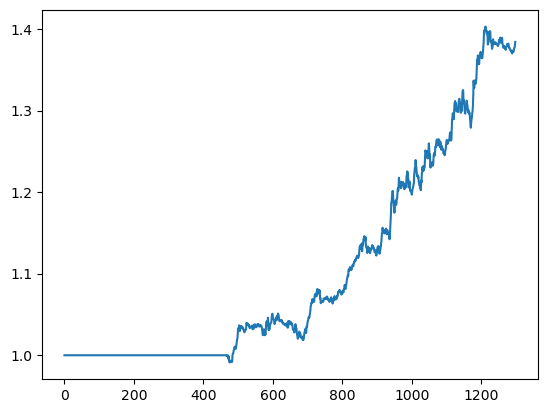

In [240]:
plt.plot((out.detach().numpy()+1).cumprod())[-280:]

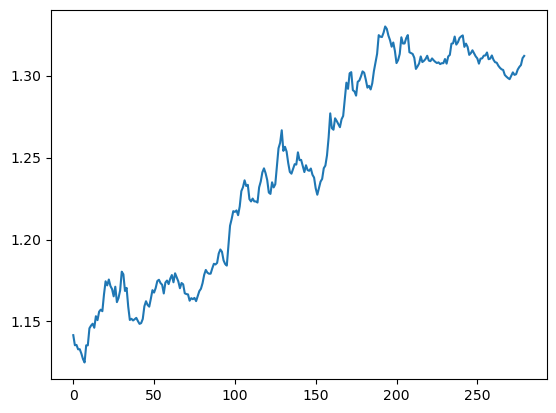

In [241]:
plt.plot((rets + 1).cumprod()[-280:])

In [42]:
def visualize_model(net, n_samples=15):
    z_values    = torch.linspace(-3, 3, n_samples)
    sigmas      = torch.linspace(0, 0.3, n_samples)
    pairs = np.array([[-z_val,-sigma] for z_val in z_values 
                                         for sigma in sigmas])
    states = torch.Tensor([[z_val, 0, sigma, 0.99] for z_val, sigma in pairs])
    weights = net(states).reshape(n_samples,n_samples).detach().numpy()

    #maxq, policy = q_values.max(-1) # returns max, argmax
    #policy = policy.detach().numpy().astype(str)
    #policy[policy=='0'] = u'←'
    #policy[policy=='1'] = u'→'
    #maxq = maxq.detach().numpy()
    fig, ax = plt.subplots()
    im = ax.imshow(weights)
    ax.set_title("Q function and Policy visualization")
    fig.tight_layout()
    plt.colorbar(im)
    #for i in range(n_samples):
    #    for j in range(n_samples):
    #        text = ax.text(j, i, policy[i,j],
    #                           ha="center", va="center", color="w", fontsize=10)

    #span = [0,4,7,10,14]# np.arange(0,n_samples,n_samples//5 +1)
    #plt.xticks(span, np.around(z_values[span].numpy(), 2))
    #plt.yticks(span, np.around(sigmas[span].numpy(), 2))
    plt.xlabel("theta")
    plt.ylabel("theta dot")
    plt.show()

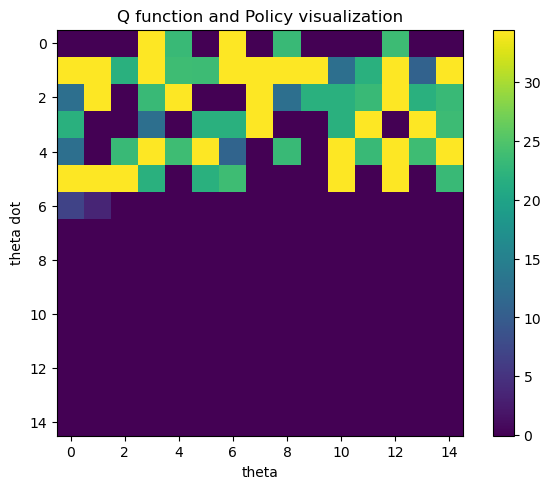

In [43]:
visualize_model(model)

### 4) Backtesting the model

In [340]:
def backtest(returns, model, res_cov_window_size=252, loadings_window_size=30, amount_of_factors=5, lookback:int=30,
             length_training=1000, retrain_freq=250, trans_cost=0.0001):
    # pre-processing for the model
    residuals, residual_weights = pca(returns, res_cov_window_size = res_cov_window_size, 
                                     loadings_window_size=loadings_window_size, amount_of_factors=amount_of_factors)
    T    = len(returns)
    out  = pd.DataFrame(index= pct_ret.index, columns=['returns'])
    # run train/test over dataset
    for t in range(int((T-length_training) / retrain_freq ) + 1): 
        print(f'AT SUBPERIOD {t}/{int((T-length_training)/retrain_freq)+1}')
        data_train_t                = returns[t*retrain_freq:length_training+t*retrain_freq]
        data_test_t                 = returns[length_training+t*retrain_freq-lookback:min(length_training+(t+1)*retrain_freq,T)]

        residual_weights_train_t    = residual_weights[t*retrain_freq:length_training+t*retrain_freq]
        residual_weights_test_t     = residual_weights[length_training+t*retrain_freq-lookback:min(length_training+(t+1)*retrain_freq,T)]
        
        residuals_train_t           = residuals[t*retrain_freq:length_training+t*retrain_freq]
        residuals_test_t            = residuals[length_training+t*retrain_freq-lookback:min(length_training+(t+1)*retrain_freq,T)]

        #training the model 
        _, sharpe_train             = train(model, data_train_t, residuals_train_t, preprocess_ou, 
                                            residual_weights_train_t, objective='sharpe',trans_cost=trans_cost, 
                                            verbose=False)
        print('final sharpe train of epoch {}: {}'.format(t, sharpe_train))
        #running the model
        returns_model               = get_returns(model, data_test_t, residuals_test_t, preprocess_ou, 
                                                  residual_weights_test_t, trans_cost=trans_cost)
        out[length_training+t*retrain_freq:min(length_training+(t+1)*retrain_freq,T)] = (returns_model.unsqueeze(1).detach().numpy())
    return out
        

In [341]:
model = OUFFN('logs')
out = backtest(pct_ret, model, res_cov_window_size=252, loadings_window_size=30, amount_of_factors=5, lookback=30,
                length_training=1000, retrain_freq=250, trans_cost=0.0001)

AT SUBPERIOD 0/4
Start OU preprocess
Finish OU preprocess
final sharpe train of epoch 0: 1.618393087787456
Start OU preprocess
Finish OU preprocess
AT SUBPERIOD 1/4
Start OU preprocess
Finish OU preprocess
final sharpe train of epoch 1: 2.806473789361428
Start OU preprocess
Finish OU preprocess
AT SUBPERIOD 2/4
Start OU preprocess
Finish OU preprocess
final sharpe train of epoch 2: 3.1800708632817445
Start OU preprocess
Finish OU preprocess
AT SUBPERIOD 3/4
Start OU preprocess
Finish OU preprocess
final sharpe train of epoch 3: 2.726673056604619
Start OU preprocess
Finish OU preprocess


returns    0.448382
dtype: float64


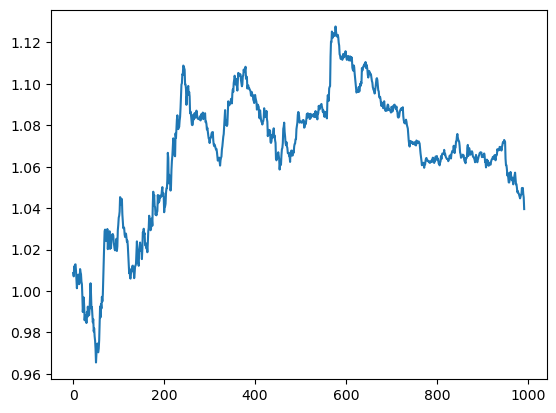

In [342]:
print((out.mean() / out.std())*np.sqrt(365*2)) # 4 8 16 8 Relu and 125 frequency and 1000 window 
plt.plot((out.dropna().values + 1).cumprod())

returns   -0.407913
dtype: float64


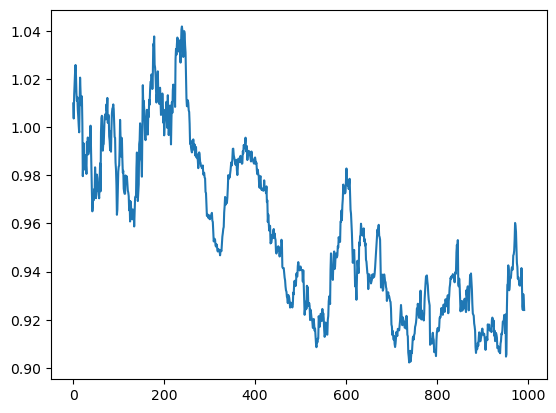

In [324]:
print((out.mean() / out.std())*np.sqrt(365*2)) # 4 8 16 8 Relu and 125 frequency and 1000 window no dropout
plt.plot((out.dropna().values + 1).cumprod())

returns    0.381087
dtype: float64


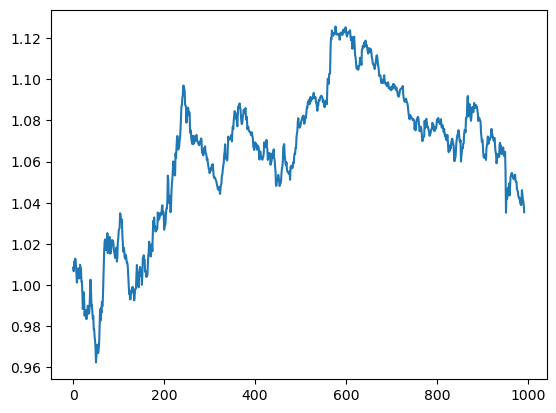

In [320]:
print((out.mean() / out.std())*np.sqrt(365*2)) # 4 8 16 8 Relu and 125 frequency and 1000 window
plt.plot((out.dropna().values + 1).cumprod())

returns    0.025937
dtype: float64


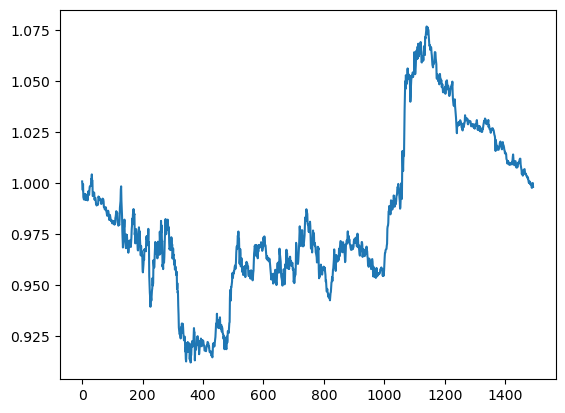

In [310]:
print((out.mean() / out.std())*np.sqrt(365*2)) # 4 8 16 8 Relu and 125 frequency and 500 window
plt.plot((out.dropna().values + 1).cumprod())

returns    1.134973
dtype: float64


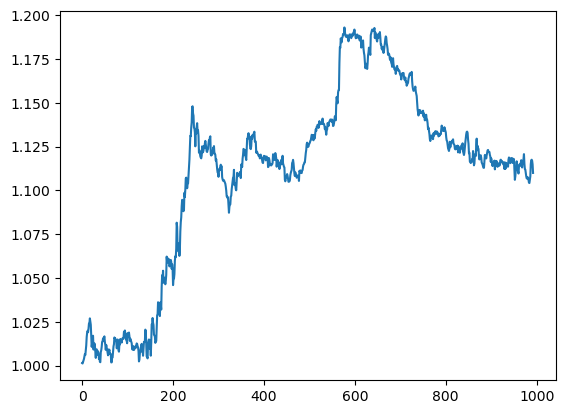

In [305]:
print((out.mean() / out.std())*np.sqrt(365*2)) # 4 8 16 8 Relu and 125 frequency
plt.plot((out.dropna().values + 1).cumprod())

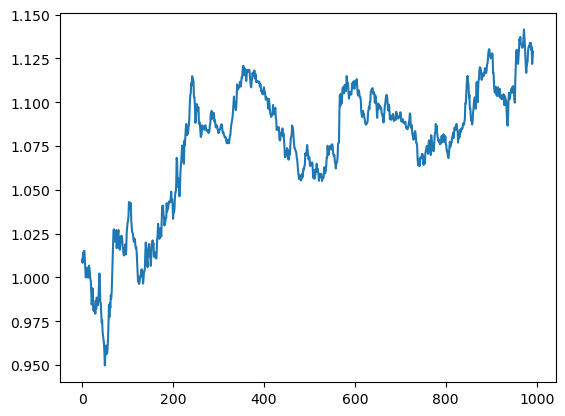

In [279]:
plt.plot((out.dropna().values + 1).cumprod()) #0.01% transaction costs

### Work to DO:
- get access to futures data: check
- create true backtest
- finish test function
- run true backtest on a truely out of sample dataset (data from 2023)